# Food Deserts Model Implementation

Group Members: Nathan Deron, Jeremiah Humes, Devraj Kori, Meredith Meadows

## Setup

In [1]:
# Import packages
from gurobipy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load in the data
vacant_lots = pd.read_csv('data/vacant_lots_centroid.csv')
travel_times = pd.read_csv('data/travel_times_all.csv')
travel_costs = pd.read_csv('data/travel_costs_all.csv')
supermarkets = pd.read_csv('data/supermarkets.csv')
addresses = pd.read_csv('data/pittsburgh_all.csv')
#add a price score index column ranging from 0 to 2 instead of from 1 to 3
supermarkets['price_score_index']=supermarkets['price score']-1


In [3]:
#Extract the relevant variables and put into numpy arrays
D = travel_costs.iloc[:,2:].to_numpy(dtype = float)
T = travel_times.iloc[:,2:].to_numpy(dtype = float)

## Define Parameters

In [4]:
#Create generators for variable indexes
households = range(len(D)) #indexed by i
store_type = range(3) #not sure about this one yet
location = range(T.shape[1]) #indexed by k, 0-60 = grocery stores, 61-99 = vacant lot

#Create O[k] - convenience store identifier
#Logic: len(supermarkets) is number of stores, get a list of ones of this length
#number of lots is number of columns in either travel_times or travel_costs minus number of stores
#since they are all columns in the same matrix, make a list of zeros of this size
#Add both lists together
number_of_stores = len(supermarkets)
number_of_lots = T.shape[1] - number_of_stores

#create an array of zeros 
O = np.zeros([3,number_of_lots+number_of_stores],dtype=int)

#Make O[j,k]=1 if a store of type j exists at lot k
#since lots go first in the cost matrices, iterate through s, where k = number_of_lots+s
for j in store_type:
    for s in range(number_of_stores):
        if supermarkets.iloc[s]['price_score_index']==j:
            #since the lots go before supermarkets, add number of lots to s before modifying the O
            O[j,number_of_lots+s] = 1


#Create E[k] - the cost of building a store at location k
#estimated cost of building the store + the cost of acquiring the lot
#Construction cost = 17,000 sq ft * $78.57 per sq ft
constr_cost = 17000 * 78.57

#Get the lot prices
lot_prices = list(vacant_lots['LOCALLAND__asmt'])

#Create E[k] based on O[k] - doesn't matter what price for non-vacant areas set to
E = [constr_cost + lot_prices[i] for i in range(number_of_lots)]+[9999999]*number_of_stores


#Define the lambda penalty

#Generate store preference for each household
#Separate by each third of the income distribution
addresses['prefs'] = pd.qcut(addresses['simulated_income'], 3, labels = [1, 2, 3])

lambda_penalty = 7.5
lamb = []
for i in households:
    pref = [lambda_penalty if addresses['prefs'][i] != j else 0 for j in store_type]
    lamb.append(pref)
lamb = np.array(lamb)

# Construct Z[i,k] = 1 if household travels time exceeds 20 minutes, 0 otherwise
# travel time is in hours, so convert 20 minutes to hours
cutoff = 20
cutoff_hours = cutoff/60

#Take travel times, replace any value greater than the cuttoff with 1, 0 otherwise
Z = np.where(T > cutoff_hours, 1, 0)

#Construct the delta matrix
#Difference between cutoff and travel time
Z = (T - cutoff_hours)*Z

#Finally, convert Z to minutes
Z = Z*60

#Set Delta penalty
delta = 2


## Gurobi Implementation - Decision Vars, Objective Terms, and Constraints

In [5]:
#Initialize the model
m = Model(name = 'Food_Deserts')

#Define decision variables
X = m.addVars(store_type, location, vtype = GRB.BINARY, name = 'X_jk')
Y = m.addVars(households, store_type, location, vtype = GRB.BINARY, name = 'Y_ijk')

#Define the objective terms
#Total Construction cost
BUILD_COST = LinExpr()

for j in store_type:
    for k in location:
        BUILD_COST += X[j,k]*E[k]
        
#Total Access cost
ACCESS_COST = LinExpr()

for j in store_type:
    for i in households:
        for k in location:
            ACCESS_COST += Y[i,j,k] * (D[i,k] + Z[i,k]*delta + lamb[i,j]) * 52 * 2

#Define the constraints

#Can only build on vacant land

for k in location:
    m.addConstr(X[j,k] <= 1 - sum(O[j,k] for j in store_type))

#Can only build one store on each lot k
for k in location:
    m.addConstr(sum(X[j,k] for j in store_type) <=1)

#Can only shop at existing or built store
for i in households:
    for j in store_type:
        for k in location:
                    m.addConstr(Y[i,j,k] <= O[j,k] + X[j,k])

#build max of 5 stores
m.addConstr( sum(X[j,k] for j in store_type for k in location) <= 5)

#Customer assignment
for i in households:
    m.addConstr( sum(Y[i,j,k] for j in store_type for k in location) == 1 )

Using license file /Users/devrajkori/gurobi.lic
Academic license - for non-commercial use only


## Add Goals Weights, Set Objective, and Solve

In [9]:
#Initialize an empty list to store tuples
#tuple = (construction cost, access cost)
results = []

#Define alpha values to use
step = 0.0001
alphas = np.arange(0, 1+step, step)

counter = 0
for alpha in alphas:
    #add this condition so the for loop breaks if the alpha is high enough to stop building stores
    if counter==0 or sum(X[(j,k)].x for j in store_type for k in location)>1:
        counter+=1
        m.setObjective((alpha*BUILD_COST/len(households)) + ((1-alpha)*ACCESS_COST/len(households)), GRB.MINIMIZE)
        m.setParam('OutputFlag', 0)
        m.optimize()
        results.append((BUILD_COST.getValue()/len(households),
                        ACCESS_COST.getValue()/len(households),
                        str(sum(X[(j,k)].x for j in store_type for k in location))))
        print('Alpha: ', str(alpha))
        print('Optimal Construction Cost: ', str(round(BUILD_COST.getValue(), 2)))
        print('Optimal Access Cost: ', str(round(ACCESS_COST.getValue(), 2)))
        print('Total Objective Function Value: ', str(round(m.objVal, 2)))
        print('Stores built: ',str(sum(X[(j,k)].x for j in store_type for k in location)))
        print()

Alpha:  0.0
Optimal Construction Cost:  15388759.0
Optimal Access Cost:  462178.45
Total Objective Function Value:  633.12
Stores built:  5.0

Alpha:  0.0001
Optimal Construction Cost:  15388759.0
Optimal Access Cost:  462178.45
Total Objective Function Value:  635.17
Stores built:  5.0

Alpha:  0.0002
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective Function Value:  637.0
Stores built:  5.0

Alpha:  0.00030000000000000003
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective Function Value:  637.86
Stores built:  5.0

Alpha:  0.0004
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective Function Value:  638.72
Stores built:  5.0

Alpha:  0.0005
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective Function Value:  639.59
Stores built:  5.0

Alpha:  0.0006000000000000001
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective 

Stores built:  5.0

Alpha:  0.0055000000000000005
Optimal Construction Cost:  6759350.0
Optimal Access Cost:  463750.99
Total Objective Function Value:  682.71
Stores built:  5.0

Alpha:  0.0056
Optimal Construction Cost:  5412160.0
Optimal Access Cost:  471336.76
Total Objective Function Value:  683.57
Stores built:  4.0

Alpha:  0.0057
Optimal Construction Cost:  4041570.0
Optimal Access Cost:  479168.19
Total Objective Function Value:  684.21
Stores built:  3.0

Alpha:  0.0058000000000000005
Optimal Construction Cost:  4041570.0
Optimal Access Cost:  479168.19
Total Objective Function Value:  684.7
Stores built:  3.0

Alpha:  0.0059
Optimal Construction Cost:  4041570.0
Optimal Access Cost:  479168.19
Total Objective Function Value:  685.19
Stores built:  3.0

Alpha:  0.006
Optimal Construction Cost:  4041570.0
Optimal Access Cost:  479168.19
Total Objective Function Value:  685.67
Stores built:  3.0

Alpha:  0.0061
Optimal Construction Cost:  4041570.0
Optimal Access Cost:  479168.

# Results - Plot Pareto Frontier

Text(0, 0.5, 'Average Annual Access Cost (USD)')

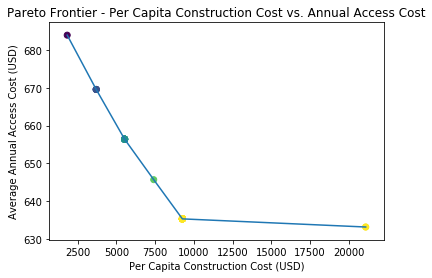

In [10]:
#Get x and y vectors from the results
x = [BUILD_COST for (BUILD_COST, ACCESS_COST, stores_built) in results]
y = [ACCESS_COST for (BUILD_COST, ACCESS_COST,stores_built) in results]
c = [int(float(stores_built)) for (BUILD_COST, ACCESS_COST,stores_built) in results]
#Plot the results
plt.plot(x,y)
plt.scatter(x,y,c=c)
plt.title('Pareto Frontier - Per Capita Construction Cost vs. Annual Access Cost')
plt.xlabel('Per Capita Construction Cost (USD)')
plt.ylabel('Average Annual Access Cost (USD)')

In [11]:
#identify stores built in the optimal solution for alpha = .001
#create a list of alphas for frontier: 
alphas = [.001,.0056,.006, .0072, 0.0077]


# loop through alphas, retrieve vacant lot rows
for alpha in alphas:
    m.setObjective((alpha*BUILD_COST/len(households)) + ((1-alpha)*ACCESS_COST/len(households)), GRB.MINIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()

    stores_built = []
    for j in store_type:
        for k in location:
            if X[(j,k)].x==1:
                stores_built.append(k)
    lots_built_alpha = vacant_lots.iloc[stores_built]
    lots_built_alpha['alpha'] = alpha
    #bind rows
    if alpha == .001:
        lots_built = lots_built_alpha
    else:
        lots_built = pd.concat([lots_built,lots_built_alpha])
lots_built

/Users/devrajkori/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,X,Y,FAIRMARKETBUILDING__asmt,PROPERTYZIP__asmt,FAIRMARKETLAND__asmt,SALECODE__asmt,LEGAL1__asmt,PROPERTYFRACTION__asmt,PIN,NEIGHDESC__asmt,...,NEIGHCODE__asmt,LOCALTOTAL__asmt,SALEPRICE__asmt,COUNTYLAND__asmt,PROPERTYSTATE__asmt,LOCALBUILDING__asmt,USEDESC__asmt,COUNTYTOTAL__asmt,MUNIDESC__asmt,alpha
144,-80.015352,40.397058,0,15226,1000,3,W C STILLWAGON PLAN BLK M & N 1.92 A LD EDGEWOO,,0061J00088000000,11903,...,11903,1000,1.0,1000,PA,0,VACANT LAND,1000,19th Ward - PITTSBURGH,0.0010
238,-79.987213,40.423050,0,15203,34900,4,1.35 A LD BROSVILLE ST BET AMANDA & MONASTERY T,,0014C00138000000,11702,...,11702,34900,113000.0,34900,PA,0,VACANT LAND,34900,17th Ward - PITTSBURGH,0.0010
7,-80.002595,40.402214,0,15226,4200,N,IRREG LOT 218.94X218.26X221.52 TIMBERLAND AVE,,0061D00065000000,11903,...,11903,4200,0.0,4200,PA,0,VACANT LAND,4200,19th Ward - PITTSBURGH,0.0010
64,-79.919878,40.371337,0,15207,29300,H,KENNEDY PLAN OF LOTS,,0185H00199000000,13102,...,13102,29300,10000.0,29300,PA,0,VACANT LAND,29300,31st Ward - PITTSBURGH,0.0010
224,-80.048637,40.442716,0,15220,11500,H,1.95 A LD STEUBEN ST,,0019A00012000000,12802,...,12802,11500,128000.0,11500,PA,0,VACANT LAND,11500,28th Ward - PITTSBURGH,0.0010
144,-80.015352,40.397058,0,15226,1000,3,W C STILLWAGON PLAN BLK M & N 1.92 A LD EDGEWOO,,0061J00088000000,11903,...,11903,1000,1.0,1000,PA,0,VACANT LAND,1000,19th Ward - PITTSBURGH,0.0056
238,-79.987213,40.423050,0,15203,34900,4,1.35 A LD BROSVILLE ST BET AMANDA & MONASTERY T,,0014C00138000000,11702,...,11702,34900,113000.0,34900,PA,0,VACANT LAND,34900,17th Ward - PITTSBURGH,0.0056
7,-80.002595,40.402214,0,15226,4200,N,IRREG LOT 218.94X218.26X221.52 TIMBERLAND AVE,,0061D00065000000,11903,...,11903,4200,0.0,4200,PA,0,VACANT LAND,4200,19th Ward - PITTSBURGH,0.0056
64,-79.919878,40.371337,0,15207,29300,H,KENNEDY PLAN OF LOTS,,0185H00199000000,13102,...,13102,29300,10000.0,29300,PA,0,VACANT LAND,29300,31st Ward - PITTSBURGH,0.0056
144,-80.015352,40.397058,0,15226,1000,3,W C STILLWAGON PLAN BLK M & N 1.92 A LD EDGEWOO,,0061J00088000000,11903,...,11903,1000,1.0,1000,PA,0,VACANT LAND,1000,19th Ward - PITTSBURGH,0.0060


In [195]:
lots_built.to_csv("data/lots built at different alphas.csv")

-0.0